In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import CactusDataset
from sklearn.metrics import roc_curve, auc


In [2]:
#use_gpu = torch.cuda.is_available()
#if use_gpu:
#    print("Using CUDA")

In [11]:
data_dir = '../../../data/train/train'
csv_file = '../../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

#set the transforms for the images
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])


torch.manual_seed(42)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])

image_datasets = {TRAIN: train_dataset, VAL: eval_dataset, TEST: test_dataset}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

batch_sizes = {TRAIN: dataset_sizes[TRAIN], VAL: dataset_sizes[VAL], TEST: 64}

dataloaders = {TRAIN: None, VAL: None, TEST: None}
dataloaders[TRAIN] = DataLoader(image_datasets[TRAIN], batch_size=batch_sizes[TRAIN],
                                             shuffle=True, num_workers=0)
dataloaders[VAL] = DataLoader(image_datasets[VAL], batch_size=batch_sizes[VAL],
                                             shuffle=False, num_workers=0)
dataloaders[TEST] = DataLoader(image_datasets[TEST], batch_size=batch_sizes[TEST], shuffle=False, num_workers=0)


print(dataset_sizes)
class_names = {0: 'No Cactus', 1: 'Cactus'}

inputs, classes = next(iter(dataloaders[TRAIN]))

n_features = 32 * 32 * 3

print(n_features)

#print nunmber of each class in each dataset
for x in [TRAIN, VAL, TEST]:
    print("Number of {} images: {}".format(x, dataset_sizes[x]))
    for i in range(2):
        print("Number of {} images of class {}: {}".format(x, class_names[i], sum([1 for j in image_datasets[x] if j[1] == i])))
    print()




{'train': 12250, 'val': 3500, 'test': 1750}
3072
Number of train images: 12250
Number of train images of class No Cactus: 3077
Number of train images of class Cactus: 9173

Number of val images: 3500
Number of val images of class No Cactus: 856
Number of val images of class Cactus: 2644

Number of test images: 1750
Number of test images of class No Cactus: 431
Number of test images of class Cactus: 1319



In [4]:
# Create model
# f = wx + b, sigmoid at the end
class LogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
    
model = LogisticRegression(n_features)

In [5]:
# Loss and optimizer
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [6]:
def train_model(model, criterion, optimizer, model_name, X_train, y_train, X_val, y_val, num_epochs=1000):
    # training loop
    num_epochs = num_epochs
    accs_train = []
    accs_val = []
    aucs = []
    best_fpr = []
    best_tpr = []
    best_auc = 0
    best_acc = 0
    #40k epoche runnate
    for epoch in range(num_epochs):
        #randomly horizontal flip the images in X_train
        transform = transforms.Compose([transforms.RandomHorizontalFlip()])
        X_train = transform(X_train)
        # forward pass and loss
        outputs = model(X_train)
        #make y_predicted and y_train of same shape
        outputs = outputs.view(-1)

        preds = outputs.round()
        acc_train = (preds == y_train).sum() / y_train.shape[0]
        accs_train.append(acc_train)

        loss = criterion(outputs, y_train.float())
        
        # backward pass
        loss.backward()
        
        # updates
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()
        
        with torch.no_grad():
            outputs = model(X_val)  # no need to call model.forward()
            y_predicted_cls = outputs.round()   # round off to nearest class
            #flatten
            y_val = y_val.view(-1)
            y_predicted_cls = y_predicted_cls.view(-1)
            #Compute accuracy
            acc = (y_predicted_cls == y_val).sum() / y_val.shape[0]   # accuracy
            accs_val.append(acc)
            #Compute AUC
            fpr, tpr, _ = roc_curve(y_val, outputs)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            if roc_auc > best_auc:
                best_auc = roc_auc
                epoch_best = epoch
                best_fpr = fpr
                best_tpr = tpr
            
    
            if acc > best_acc:
                best_acc = acc
                epoch_best = epoch
                #save the best model weights with info about PCA compoenents
                torch.save(model.state_dict(), f'../../../data/LR/'+str(model_name)+f'weights_best.pt')
            if epoch % 100 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}, Accuracy on val: {acc}')
    return accs_train, accs_val, aucs, best_fpr, best_tpr, best_auc, epoch_best

## LR without PCA

In [7]:
#Load dataset
'''X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)'''

'X_train = []\ny_train = []\nfor images, labels in dataloaders[TRAIN]:\n    images = images.view(-1, n_features)\n    X_train.append(images)\n    y_train.append(labels)\nX_train = torch.cat(X_train, dim=0)\ny_train = torch.cat(y_train, dim=0)\nX_val = []\ny_val = []\nfor images, labels in dataloaders[VAL]:\n    images = images.view(-1, n_features)\n    X_val.append(images)\n    y_val.append(labels)\nX_val = torch.cat(X_val, dim=0)\ny_val = torch.cat(y_val, dim=0)'

In [8]:
# train model for 1000 epochs
# train_model(model, criterion, optimizer, 'logistic_regression', X_train, y_train, X_val, y_val, num_epochs=1000)

## LR with PCA

In [9]:
from sklearn.decomposition import PCA

In [10]:
X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    images = images.view(-1, n_features)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)

In [11]:
# retain only n_componenets feature with highest variance using PCA
n_components = 625
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train.detach().numpy())
X_val_pca = pca.transform(X_val.detach().numpy())
#transform in tensors
X_train_pca = torch.tensor(X_train_pca)
X_val_pca = torch.tensor(X_val_pca)


In [12]:
model = LogisticRegression(X_train_pca.shape[1])
# Loss and optimizer
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
#Train model using pca features
accs_train, accs_val, aucs, best_fpr, best_tpr, best_auc, epoch_best = train_model(model, criterion, optimizer, 'logistic_regression_pca', X_train_pca, y_train, X_val_pca, y_val, num_epochs=10000)

Epoch: 0, Loss: 0.6850165724754333, Accuracy on val: 0.45971429347991943
Epoch: 100, Loss: 0.6029457449913025, Accuracy on val: 0.7614285945892334
Epoch: 200, Loss: 0.5579399466514587, Accuracy on val: 0.7905714511871338
Epoch: 300, Loss: 0.5064926147460938, Accuracy on val: 0.7882857322692871
Epoch: 400, Loss: 0.4872332513332367, Accuracy on val: 0.8028571605682373
Epoch: 500, Loss: 0.4580841064453125, Accuracy on val: 0.8077142834663391
Epoch: 600, Loss: 0.43787533044815063, Accuracy on val: 0.8131428360939026
Epoch: 700, Loss: 0.4315728545188904, Accuracy on val: 0.8202857375144958
Epoch: 800, Loss: 0.417625367641449, Accuracy on val: 0.8268571496009827
Epoch: 900, Loss: 0.39979907870292664, Accuracy on val: 0.8337143063545227
Epoch: 1000, Loss: 0.3892526626586914, Accuracy on val: 0.8360000252723694
Epoch: 1100, Loss: 0.38059547543525696, Accuracy on val: 0.8411428332328796
Epoch: 1200, Loss: 0.37365636229515076, Accuracy on val: 0.8479999899864197
Epoch: 1300, Loss: 0.372153341770

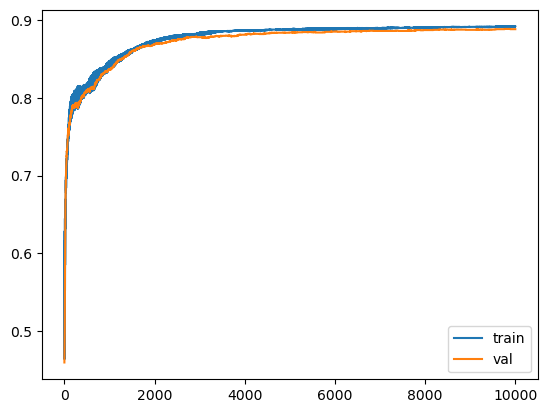

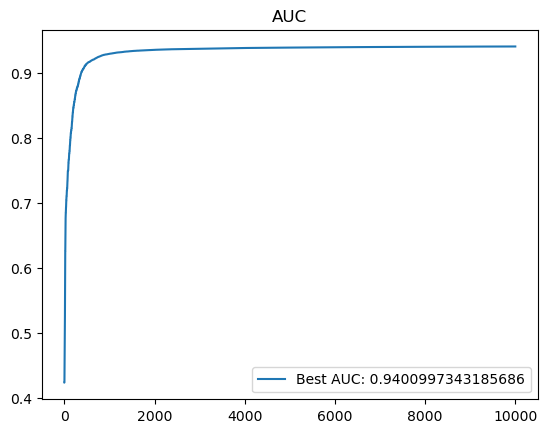

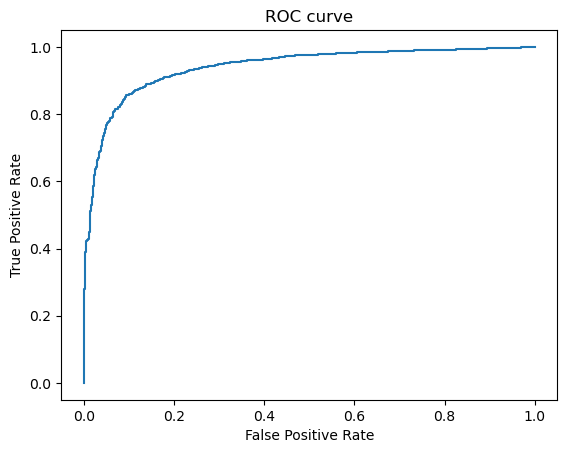

Best AUC: 0.9400997343185686
Best epoch: 9997


In [14]:
#plot accuracy train vs val
plt.plot(accs_train, label='train')
plt.plot(accs_val, label='val')
plt.legend()
plt.show()
#plot AUC
plt.plot(aucs)
#add legend with best AUC
plt.legend([f'Best AUC: {best_auc}'])
plt.title('AUC')
plt.show()
#plot ROC
plt.plot(best_fpr, best_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()
print('Best AUC:', best_auc)
print('Best epoch:', epoch_best)

## LR using only grayscale values

In [15]:
'''data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = '../../../data/train/train'
csv_file = '../../../data/train.csv'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'


np.random.seed(0)
image_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)
# split into train, eval, test
train_size = int(0.7 * len(image_dataset))
eval_size = int(0.2 * len(image_dataset))
test_size = len(image_dataset) - train_size - eval_size
train_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])

image_datasets = {TRAIN: train_dataset, VAL: eval_dataset, TEST: test_dataset}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

batch_sizes = {TRAIN: dataset_sizes[TRAIN], VAL: dataset_sizes[VAL], TEST: 64}

dataloaders = {TRAIN: None, VAL: None, TEST: None}
dataloaders[TRAIN] = DataLoader(image_datasets[TRAIN], batch_size=batch_sizes[TRAIN],
                                             shuffle=True, num_workers=0)
dataloaders[VAL] = DataLoader(image_datasets[VAL], batch_size=batch_sizes[VAL],
                                             shuffle=False, num_workers=0)
dataloaders[TEST] = DataLoader(image_datasets[TEST], batch_size=batch_sizes[TEST], shuffle=False, num_workers=0)


print(dataset_sizes)
class_names = {0: 'No Cactus', 1: 'Cactus'}

inputs, classes = next(iter(dataloaders[TRAIN]))

n_features = 32 * 32

print(n_features)'''


"data_transforms = transforms.Compose([\n    transforms.Grayscale(num_output_channels=1),\n    transforms.ToTensor()\n])\n\ndata_dir = '../../../data/train/train'\ncsv_file = '../../../data/train.csv'\nTRAIN = 'train'\nVAL = 'val'\nTEST = 'test'\n\n\nnp.random.seed(0)\nimage_dataset = CactusDataset.CactusDataset(csv_file, data_dir, data_transforms)\n# split into train, eval, test\ntrain_size = int(0.7 * len(image_dataset))\neval_size = int(0.2 * len(image_dataset))\ntest_size = len(image_dataset) - train_size - eval_size\ntrain_dataset, eval_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, eval_size, test_size])\n\nimage_datasets = {TRAIN: train_dataset, VAL: eval_dataset, TEST: test_dataset}\n\ndataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}\n\nbatch_sizes = {TRAIN: dataset_sizes[TRAIN], VAL: dataset_sizes[VAL], TEST: 64}\n\ndataloaders = {TRAIN: None, VAL: None, TEST: None}\ndataloaders[TRAIN] = DataLoader(image_datasets[TRAIN]

In [16]:
#Load data
'''X_train = []
y_train = []
for images, labels in dataloaders[TRAIN]:
    images = images.view(-1, n_features)
    print(images.shape)
    X_train.append(images)
    y_train.append(labels)
X_train = torch.cat(X_train, dim=0)
y_train = torch.cat(y_train, dim=0)
X_val = []
y_val = []
for images, labels in dataloaders[VAL]:
    images = images.view(-1, n_features)
    X_val.append(images)
    y_val.append(labels)
X_val = torch.cat(X_val, dim=0)
y_val = torch.cat(y_val, dim=0)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)'''

'X_train = []\ny_train = []\nfor images, labels in dataloaders[TRAIN]:\n    images = images.view(-1, n_features)\n    print(images.shape)\n    X_train.append(images)\n    y_train.append(labels)\nX_train = torch.cat(X_train, dim=0)\ny_train = torch.cat(y_train, dim=0)\nX_val = []\ny_val = []\nfor images, labels in dataloaders[VAL]:\n    images = images.view(-1, n_features)\n    X_val.append(images)\n    y_val.append(labels)\nX_val = torch.cat(X_val, dim=0)\ny_val = torch.cat(y_val, dim=0)\nprint(X_train.shape)\nprint(y_train.shape)\nprint(X_val.shape)\nprint(y_val.shape)'

In [17]:
'''model = LogisticRegression(n_features)
# Loss and optimizer
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)'''

'model = LogisticRegression(n_features)\n# Loss and optimizer\nlearning_rate = 0.01\ncriterion = nn.BCELoss()\noptimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)'

In [18]:
#train_model(model, criterion, optimizer, 'logistic_regression_grayscale', X_train, y_train, X_val, y_val, num_epochs=1000)